# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
555,G62087174h,Renault Kaptur,standart,petrol,4.60,2011,2306,2020,38.81,electro_bug
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake
2086,V-1493273B,Renault Sandero,standart,petrol,6.02,2015,74211,2019,37.61,engine_fuel
1567,Z-1984492i,Kia Rio,economy,petrol,5.18,2011,3357,2018,28.92,break_bug
835,K-1703648s,Kia Rio,economy,petrol,5.32,2013,37237,2020,89.66,another_bug


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
55241,j29138086P,D28621238x,e1j,2020-02-14,6.86,2,11,49,75.0,0,1.063886e+02,0,1.394878,-0.001
275831,x13672334o,T-2050577H,N1s,2020-01-22,3.71,57,678,48,147.0,0,2.565229e+03,0,3.406888,18.694
306767,A13002341G,V21472170q,f1J,2020-01-03,4.39,35984,323848,47,58.0,3,1.722922e+06,0,4.068637,-0.000
193218,B45150822u,N18887406C,Q1j,2020-02-11,5.54,42,372,50,81.0,0,2.148534e+03,0,0.600712,-9.905
254129,F26068039Q,R22962581A,T1U,2020-02-17,4.54,28,331,55,74.0,0,1.465951e+03,0,-14.970250,-0.352


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
9346,43,7.6,996,3.0,n30472091T,0,2019-2-25
2077,43,8.4,1691,15.0,j15501867O,0,2021-7-27
4942,30,8.1,403,7.0,P97619172k,0,2019-7-29
6958,46,6.6,869,2.0,V14819276q,0,2020-9-27
858,33,8.2,2,16.0,I19130528V,1,2019-11-15


In [5]:
driver_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15153 entries, 0 to 15152
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 15153 non-null  int64  
 1   user_rating         15153 non-null  float64
 2   user_rides          15153 non-null  int64  
 3   user_time_accident  14182 non-null  float64
 4   user_id             15153 non-null  object 
 5   sex                 15153 non-null  int64  
 6   first_ride_date     15153 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 828.8+ KB


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [6]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
4044,b13641719v,NS,2020-2-28 3:10,repair,3.8,6
33778,M16685844b,SB,2020-8-13 16:36,repair,6.2,23
72481,E15850759P,NC,2020-6-17 19:1,repair,5.9,18
8427,t24316205h,HJ,2019-4-27 2:22,refuel,1.0,18
106507,I-9571675o,VR,2019-9-12 14:41,repair,5.6,11


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [ ]:
# Пример расчета одного признака
rides_info.groupby('car_id', as_index=False).agg(
    mean_rating = ('rating', 'mean'),
    # ... еще признаки
)

df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# YOUR CODE HERE

TypeError: merge() missing 1 required positional argument: 'right'

### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [7]:
# Группировка по car_id и расчет требуемых метрик
riders_info_new = rides_info.groupby('car_id').agg(
    min_rating = ('rating', 'min'), # минимальный рейтинг за все поездки
    average_rating = ('rating', 'mean'), # средний рейтинг за все поездки
    total_distance = ('distance', 'sum'), # общее количество километров, которое машина проехала
    max_speed = ('speed_max', 'max'), # максимальная скорость
    total_rides = ('ride_duration', 'sum'), # общее количество поездок для каждой машины если считать количество то получается на каждую машину 174 поездки
    # это явно не то что вы имели ввиду и сам признак вообще не информативен, я подумал что имелось ввиду общая длительность поездок

    # Генерация дополнительных признаков
    average_stop_times = ('stop_times', 'mean'), # среднее количество остановок
    average_ride_duration = ('ride_duration', 'mean'), # средняя дальность поездки
    feature_quant = ('deviation_normal', lambda x: x.quantile(0.75)) # % квантиль
).reset_index()

riders_info_new.head()

,car_id,min_rating,average_rating,total_distance,max_speed,total_rides,average_stop_times,average_ride_duration,feature_quant
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.53250
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,373893,0.827586,2148.810345,59.06075
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,83349,4.143678,479.017241,17.22600
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,377151,0.758621,2167.534483,25.68825
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,249971,0.890805,1436.614943,31.29600


In [8]:
riders_new = pd.merge(rides_info, riders_info_new, on='car_id', how='left')
riders_new

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,...,user_ride_quality,deviation_normal,min_rating,average_rating,total_distance,max_speed,total_rides,average_stop_times,average_ride_duration,feature_quant
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,...,1.115260,2.909,0.1,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,...,1.650465,4.133,0.1,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,...,2.599112,2.461,0.1,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,...,3.216255,0.909,0.1,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,...,2.716550,-1.822,0.1,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739495,I15732675M,z91796444U,m1z,2020-03-30,7.42,164,2290,49,54.586302,0,...,6.137593,-39.752,0.1,4.307471,7.453857e+06,108.653269,171902,0.747126,987.942529,-16.0715
739496,r51579957X,z91796444U,t1P,2020-03-30,4.19,26,412,46,73.000000,0,...,6.703367,-38.480,0.1,4.307471,7.453857e+06,108.653269,171902,0.747126,987.942529,-16.0715
739497,l15212727I,z91796444U,z1A,2020-03-31,3.40,23,178,37,71.000000,1,...,6.255344,-45.080,0.1,4.307471,7.453857e+06,108.653269,171902,0.747126,987.942529,-16.0715
739498,Z78949958q,z91796444U,w1R,2020-04-01,9.02,5,75,48,87.000000,1,...,7.759949,-60.193,0.1,4.307471,7.453857e+06,108.653269,171902,0.747126,987.942529,-16.0715


In [ ]:
riders_info_new["total_rides"].unique()

array([174])

In [9]:
driver_info.head()

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,19.0,l17437965W,1,2019-4-2
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19
2,59,7.8,947,4.0,g11098715c,0,2021-1-15
3,37,7.0,18,4.0,U12618125q,0,2019-11-20
4,39,8.2,428,7.0,A14375829B,0,2019-7-23


In [10]:
# Присоеденим к нашему датасету 3 новых признакка из данных о овдителях пол, возраст, рейтинг
rides_driver_info = pd.merge(riders_new, driver_info[['user_id', 'user_rating', 'sex', 'age']], on='user_id', how='left')
rides_driver_info

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,...,average_rating,total_distance,max_speed,total_rides,average_stop_times,average_ride_duration,feature_quant,user_rating,sex,age
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,...,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325,8.0,1,18
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,...,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325,7.0,0,40
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,...,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325,7.7,1,32
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,...,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325,7.7,0,35
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,...,4.255172,1.125753e+07,179.729652,224292,0.816092,1289.034483,-0.5325,7.6,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739495,I15732675M,z91796444U,m1z,2020-03-30,7.42,164,2290,49,54.586302,0,...,4.307471,7.453857e+06,108.653269,171902,0.747126,987.942529,-16.0715,7.3,0,39
739496,r51579957X,z91796444U,t1P,2020-03-30,4.19,26,412,46,73.000000,0,...,4.307471,7.453857e+06,108.653269,171902,0.747126,987.942529,-16.0715,8.0,1,33
739497,l15212727I,z91796444U,z1A,2020-03-31,3.40,23,178,37,71.000000,1,...,4.307471,7.453857e+06,108.653269,171902,0.747126,987.942529,-16.0715,7.6,1,18
739498,Z78949958q,z91796444U,w1R,2020-04-01,9.02,5,75,48,87.000000,1,...,4.307471,7.453857e+06,108.653269,171902,0.747126,987.942529,-16.0715,7.9,0,34


In [11]:
# Преобразуем fix_date в datetime для корректной сортировки
fix_info['fix_date'] = pd.to_datetime(fix_info['fix_date'], errors='coerce')

# Сортировка по car_id и fix_date
fix_info_sorted = fix_info.sort_values(by=['car_id', 'fix_date'], ascending=[True, False])

# Удаление дубликатов оставляя только последнюю запись о ремонте для каждого car_id
fix_info_last_record = fix_info_sorted.drop_duplicates(subset=['car_id'])

# Соединение текущего датасета с последней записью о ремонте по car_id
df = pd.merge(rides_driver_info, fix_info_last_record[['car_id', 'work_type', 'destroy_degree', 'work_duration']], on='car_id', how='left')

df.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,...,total_rides,average_stop_times,average_ride_duration,feature_quant,user_rating,sex,age,work_type,destroy_degree,work_duration
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,...,224292,0.816092,1289.034483,-0.5325,8.0,1,18,reparking,1.0,29
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,...,224292,0.816092,1289.034483,-0.5325,7.0,0,40,reparking,1.0,29
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,...,224292,0.816092,1289.034483,-0.5325,7.7,1,32,reparking,1.0,29
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,...,224292,0.816092,1289.034483,-0.5325,7.7,0,35,reparking,1.0,29
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,...,224292,0.816092,1289.034483,-0.5325,7.6,1,24,reparking,1.0,29


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739500 entries, 0 to 739499
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                739500 non-null  object 
 1   car_id                 739500 non-null  object 
 2   ride_id                739500 non-null  object 
 3   ride_date              739500 non-null  object 
 4   rating                 739500 non-null  float64
 5   ride_duration          739500 non-null  int64  
 6   ride_cost              739500 non-null  int64  
 7   speed_avg              739500 non-null  int64  
 8   speed_max              736139 non-null  float64
 9   stop_times             739500 non-null  int64  
 10  distance               739500 non-null  float64
 11  refueling              739500 non-null  int64  
 12  user_ride_quality      736872 non-null  float64
 13  deviation_normal       739500 non-null  float64
 14  min_rating             739500 non-nu

In [13]:
# Удалим пропуски
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733511 entries, 0 to 739498
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                733511 non-null  object 
 1   car_id                 733511 non-null  object 
 2   ride_id                733511 non-null  object 
 3   ride_date              733511 non-null  object 
 4   rating                 733511 non-null  float64
 5   ride_duration          733511 non-null  int64  
 6   ride_cost              733511 non-null  int64  
 7   speed_avg              733511 non-null  int64  
 8   speed_max              733511 non-null  float64
 9   stop_times             733511 non-null  int64  
 10  distance               733511 non-null  float64
 11  refueling              733511 non-null  int64  
 12  user_ride_quality      733511 non-null  float64
 13  deviation_normal       733511 non-null  float64
 14  min_rating             733511 non-nu

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [ ]:
# Линейная корреляция
df.corr(method='pearson')

,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,...,max_speed,total_rides,average_stop_times,average_ride_duration,feature_quant,user_rating,sex,age,destroy_degree,work_duration
rating,1.000000,-0.001221,-0.001022,-0.086561,-0.236448,-0.054231,-0.006342,0.001255,0.000066,-0.043141,...,-0.118485,0.001088,0.046233,0.001088,-0.047734,0.004938,-0.003280,0.001748,0.008393,0.000899
ride_duration,-0.001221,1.000000,0.912661,-0.000761,0.001105,0.009230,0.964460,0.003623,-0.000018,-0.000179,...,0.001433,0.075879,0.006050,0.075879,-0.000921,-0.000158,0.001030,-0.001984,-0.000686,-0.000896
ride_cost,-0.001022,0.912661,1.000000,-0.000281,0.000654,0.007056,0.880652,0.003143,0.000566,0.000252,...,0.002658,0.067967,0.001536,0.067967,-0.000045,0.006877,0.000341,0.000197,-0.000928,-0.001634
speed_avg,-0.086561,-0.000761,-0.000281,1.000000,0.498363,-0.131442,0.065856,0.000422,-0.005512,0.038968,...,0.136201,-0.003041,-0.096514,-0.003041,0.045499,-0.003220,-0.000763,0.000127,-0.003847,0.002151
speed_max,-0.236448,0.001105,0.000654,0.498363,1.000000,0.048073,0.033186,-0.000635,-0.005188,0.085777,...,0.347822,0.006092,0.020661,0.006092,0.084539,0.004602,0.001878,-0.002057,-0.013330,0.004381
stop_times,-0.054231,0.009230,0.007056,-0.131442,0.048073,1.000000,-0.007860,-0.000286,0.017912,0.000353,...,0.035773,0.035981,0.467022,0.035981,-0.024861,0.029847,0.004451,-0.002536,0.014101,-0.003941
distance,-0.006342,0.964460,0.880652,0.065856,0.033186,-0.007860,1.000000,0.002728,-0.000398,0.002487,...,0.009809,0.072525,-0.004124,0.072525,0.002206,-0.000423,0.001184,-0.002272,-0.001591,-0.000541
refueling,0.001255,0.003623,0.003143,0.000422,-0.000635,-0.000286,0.002728,1.000000,0.000924,-0.001042,...,-0.000214,0.000730,0.002209,0.000730,-0.001064,-0.000711,-0.001925,0.001074,-0.000698,-0.000741
user_ride_quality,0.000066,-0.000018,0.000566,-0.005512,-0.005188,0.017912,-0.000398,0.000924,1.000000,-0.011561,...,-0.026493,0.006737,0.038364,0.006737,-0.010200,-0.003001,0.004369,-0.004379,-0.003226,-0.003534
deviation_normal,-0.043141,-0.000179,0.000252,0.038968,0.085777,0.000353,0.002487,-0.001042,-0.011561,1.000000,...,0.233973,-0.002391,0.000039,-0.002391,0.670774,0.023288,0.001781,-0.001534,-0.039360,-0.000668


<AxesSubplot:>

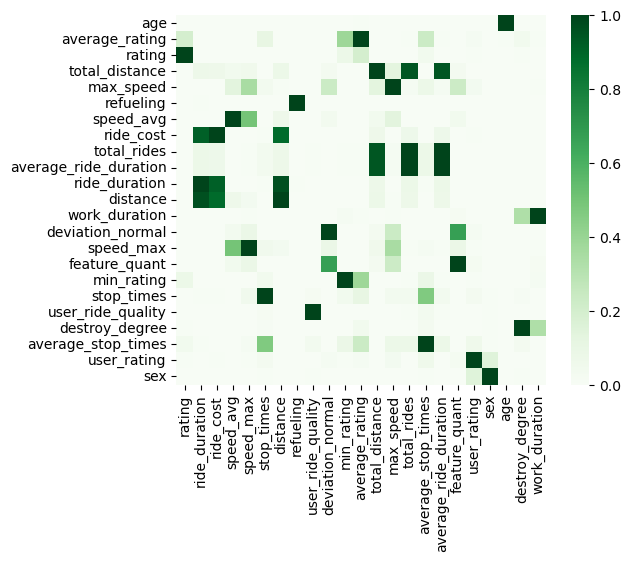

In [ ]:
corrs = df.corr().round(3).sort_values('sex')
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

**Проанализировав мы видим, что есть достаточно признаков которые коррелируют между собой по целевому показателю пола водителя**

In [ ]:
!pip install -q phik

interval columns not set, guessing: ['rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating', 'average_rating', 'total_distance', 'max_speed', 'total_rides', 'average_stop_times', 'average_ride_duration', 'feature_quant', 'user_rating', 'sex', 'age', 'destroy_degree', 'work_duration']


D:\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable car_id is large: 4250. Are you sure this is not an interval variable? Analysis for pairs of variables including car_id can be slow.
  warnings.warn(
D:\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable ride_id is large: 2704. Are you sure this is not an interval variable? Analysis for pairs of variables including ride_id can be slow.
  warnings.warn(
D:\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable user_id is large: 15153. Are you sure this is not an interval variable? Analysis for pairs of variables including user_id can be slow.
  warnings.warn(


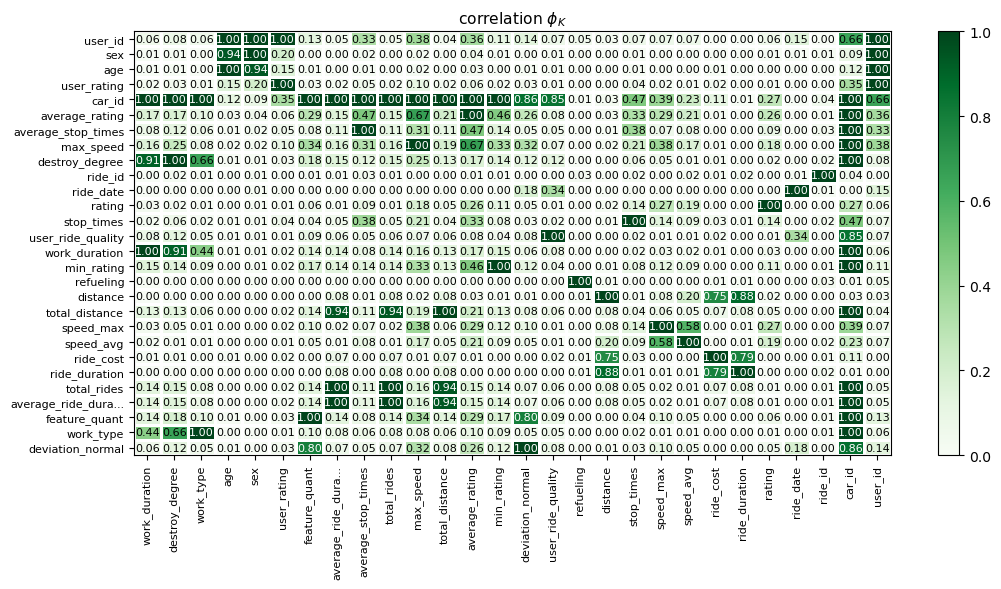

In [ ]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = df.phik_matrix().round(2).sort_values('sex')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

**Тут уже интереснее. User_id, car_id сильно коррелируют с признаками их надо удалить, так же созданные нами признак total_rides, average_ride duratation, total_distance надо будет смотреть что с ними делать. Пересчитывать не буду очень долго считалось**

interval columns not set, guessing: ['rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating', 'average_rating', 'total_distance', 'max_speed', 'total_rides', 'average_stop_times', 'average_ride_duration', 'feature_quant', 'user_rating', 'sex', 'age', 'destroy_degree', 'work_duration']


D:\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable car_id is large: 4250. Are you sure this is not an interval variable? Analysis for pairs of variables including car_id can be slow.
  warnings.warn(
D:\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable ride_id is large: 2704. Are you sure this is not an interval variable? Analysis for pairs of variables including ride_id can be slow.
  warnings.warn(
D:\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable user_id is large: 15153. Are you sure this is not an interval variable? Analysis for pairs of variables including user_id can be slow.
  warnings.warn(


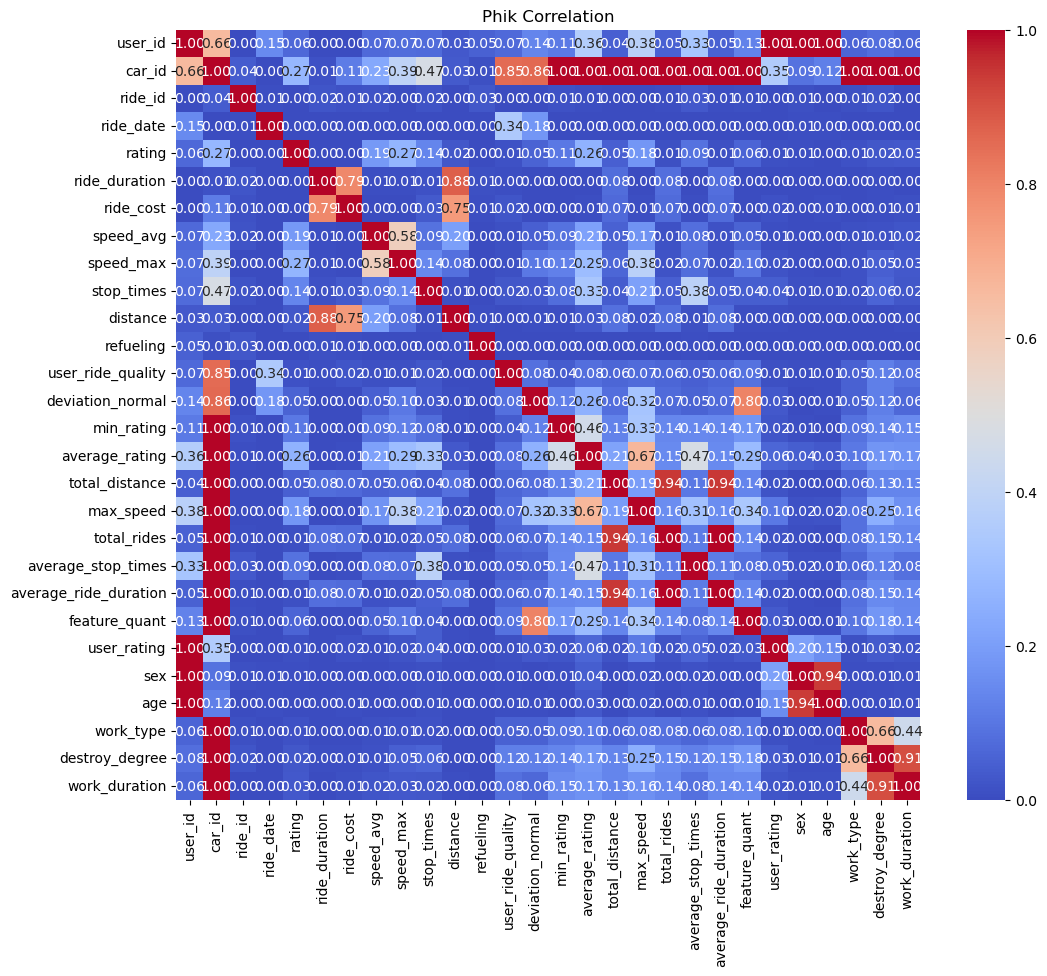

In [ ]:
# Расчет phik корреляции для датасета
from phik import resources
import matplotlib.pyplot as plt
import seaborn as sns

# Вычисление phik корреляции
phik_matrix = df.phik_matrix()

# Визуализация результатов с использованием seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Phik Correlation')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733511 entries, 0 to 739498
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                733511 non-null  object 
 1   car_id                 733511 non-null  object 
 2   ride_id                733511 non-null  object 
 3   ride_date              733511 non-null  object 
 4   rating                 733511 non-null  float64
 5   ride_duration          733511 non-null  int64  
 6   ride_cost              733511 non-null  int64  
 7   speed_avg              733511 non-null  int64  
 8   speed_max              733511 non-null  float64
 9   stop_times             733511 non-null  int64  
 10  distance               733511 non-null  float64
 11  refueling              733511 non-null  int64  
 12  user_ride_quality      733511 non-null  float64
 13  deviation_normal       733511 non-null  float64
 14  min_rating             733511 non-nu

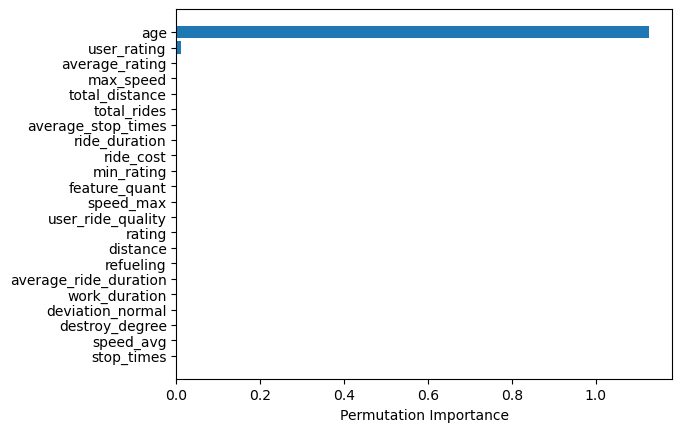

In [ ]:
# Permutation Importance

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

X = df.drop(['sex', 'car_id', 'user_id', 'ride_id', 'ride_date', 'work_type'], axis=1)
y = df['sex']

# Разделение датасета на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Расчет Permutation Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Визуализация результатов
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(range(X_test.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

**Интересная картина**

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [14]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.5 MB/s eta 0:00:00


In [15]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [16]:
df.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,...,total_rides,average_stop_times,average_ride_duration,feature_quant,user_rating,sex,age,work_type,destroy_degree,work_duration
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,...,224292,0.816092,1289.034483,-0.5325,8.0,1,18,reparking,1.0,29
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,...,224292,0.816092,1289.034483,-0.5325,7.0,0,40,reparking,1.0,29
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,...,224292,0.816092,1289.034483,-0.5325,7.7,1,32,reparking,1.0,29
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,...,224292,0.816092,1289.034483,-0.5325,7.7,0,35,reparking,1.0,29
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,...,224292,0.816092,1289.034483,-0.5325,7.6,1,24,reparking,1.0,29


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733511 entries, 0 to 739498
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                733511 non-null  object 
 1   car_id                 733511 non-null  object 
 2   ride_id                733511 non-null  object 
 3   ride_date              733511 non-null  object 
 4   rating                 733511 non-null  float64
 5   ride_duration          733511 non-null  int64  
 6   ride_cost              733511 non-null  int64  
 7   speed_avg              733511 non-null  int64  
 8   speed_max              733511 non-null  float64
 9   stop_times             733511 non-null  int64  
 10  distance               733511 non-null  float64
 11  refueling              733511 non-null  int64  
 12  user_ride_quality      733511 non-null  float64
 13  deviation_normal       733511 non-null  float64
 14  min_rating             733511 non-nu

In [18]:
df = pd.merge(df, car_train[['car_id', 'target_class']], on='car_id', how='left')
df.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,...,average_stop_times,average_ride_duration,feature_quant,user_rating,sex,age,work_type,destroy_degree,work_duration,target_class
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,...,0.816092,1289.034483,-0.5325,8.0,1,18,reparking,1.0,29,engine_overheat
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,...,0.816092,1289.034483,-0.5325,7.0,0,40,reparking,1.0,29,engine_overheat
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,...,0.816092,1289.034483,-0.5325,7.7,1,32,reparking,1.0,29,engine_overheat
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,...,0.816092,1289.034483,-0.5325,7.7,0,35,reparking,1.0,29,engine_overheat
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,...,0.816092,1289.034483,-0.5325,7.6,1,24,reparking,1.0,29,engine_overheat


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733511 entries, 0 to 733510
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                733511 non-null  object 
 1   car_id                 733511 non-null  object 
 2   ride_id                733511 non-null  object 
 3   ride_date              733511 non-null  object 
 4   rating                 733511 non-null  float64
 5   ride_duration          733511 non-null  int64  
 6   ride_cost              733511 non-null  int64  
 7   speed_avg              733511 non-null  int64  
 8   speed_max              733511 non-null  float64
 9   stop_times             733511 non-null  int64  
 10  distance               733511 non-null  float64
 11  refueling              733511 non-null  int64  
 12  user_ride_quality      733511 non-null  float64
 13  deviation_normal       733511 non-null  float64
 14  min_rating             733511 non-nu

In [20]:
df = df.dropna()
df

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,...,average_stop_times,average_ride_duration,feature_quant,user_rating,sex,age,work_type,destroy_degree,work_duration,target_class
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,...,0.816092,1289.034483,-0.5325,8.0,1,18,reparking,1.0,29,engine_overheat
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,...,0.816092,1289.034483,-0.5325,7.0,0,40,reparking,1.0,29,engine_overheat
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,...,0.816092,1289.034483,-0.5325,7.7,1,32,reparking,1.0,29,engine_overheat
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,...,0.816092,1289.034483,-0.5325,7.7,0,35,reparking,1.0,29,engine_overheat
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,...,0.816092,1289.034483,-0.5325,7.6,1,24,reparking,1.0,29,engine_overheat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733344,k46944435F,z91353693Z,a1Z,2020-03-30,4.54,53,684,46,63.000000,1,...,0.798851,2170.580460,4.7910,8.3,0,38,repair,6.7,24,break_bug
733345,C89754213L,z91353693Z,t1b,2020-03-31,4.01,20,196,38,71.622738,1,...,0.798851,2170.580460,4.7910,8.1,1,19,repair,6.7,24,break_bug
733346,c33545776U,z91353693Z,n1J,2020-03-31,8.58,43,683,40,75.653822,0,...,0.798851,2170.580460,4.7910,8.7,0,53,repair,6.7,24,break_bug
733347,q60190640n,z91353693Z,d1L,2020-04-01,7.23,53,736,49,63.000000,1,...,0.798851,2170.580460,4.7910,7.9,0,46,repair,6.7,24,break_bug


In [21]:
features2drop = ['user_id', 'car_id', 'ride_id', 'ride_date'] # то, что надо выбросить
targets = ['target_class'] # таргеты
cat_features = ['work_type'] # категориальные признаки

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in df.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 1 ['work_type']
Числовые признаки: 23 ['rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating', 'average_rating', 'total_distance', 'max_speed', 'total_rides', 'average_stop_times', 'average_ride_duration', 'feature_quant', 'user_rating', 'sex', 'age', 'destroy_degree', 'work_duration']
Целевые переменные ['target_class']


In [22]:
# YOUR CODE HERE
X = df[filtered_features].drop(targets, axis=1, errors="ignore")
y = df["target_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [35]:
# model = CatBoostClassifier(iterations=100,
#                          thread_count=-1,
#                          random_seed=12345,
#                          cat_features=cat_features)

# model.fit(
#     X_train,
#     y_train,
#     eval_set=(X_test, y_test),
#     verbose=10,
#     use_best_model=True,
#     early_stopping_rounds=50
# )

In [36]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import KFold

n_splits = 3  # Число фолдов
clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

kf = KFold(n_splits=n_splits, shuffle=True, random_state=12345)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Специальный класс для ускорения обучения
    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    clf = CatBoostClassifier(
        depth=4,
        iterations=3500,
        learning_rate=0.06,
        loss_function="MultiClass",
        custom_metric=["Accuracy"],
        cat_features=cat_features,

        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,

        # Параметры скорения
        task_type="CPU",
        thread_count=-1,
        bootstrap_type="Bernoulli",

        # Важное!
        random_seed=12345,
        auto_class_weights="SqrtBalanced",
        early_stopping_rounds=50)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=500,
        use_best_model=True,
        plot=False)

    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "Accuracy" in k], dtype="float16"))

assert len(clfs) == n_splits
print("mean Recall score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))

0:	learn: 2.1165585	test: 2.1177096	best: 2.1177096 (0)	total: 1.17s	remaining: 1h 8m 1s
500:	learn: 0.2127570	test: 0.2128230	best: 0.2128230 (500)	total: 4m 15s	remaining: 25m 27s
1000:	learn: 0.1333217	test: 0.1340917	best: 0.1340917 (1000)	total: 8m 26s	remaining: 21m 5s
1500:	learn: 0.0908706	test: 0.0919736	best: 0.0919736 (1500)	total: 12m 37s	remaining: 16m 49s
2000:	learn: 0.0643992	test: 0.0655763	best: 0.0655763 (2000)	total: 16m 40s	remaining: 12m 29s
2500:	learn: 0.0461477	test: 0.0472001	best: 0.0472001 (2500)	total: 20m 43s	remaining: 8m 16s
3000:	learn: 0.0338790	test: 0.0347669	best: 0.0347669 (3000)	total: 24m 44s	remaining: 4m 6s
3499:	learn: 0.0246958	test: 0.0254701	best: 0.0254701 (3499)	total: 28m 48s	remaining: 0us

bestTest = 0.0254701258
bestIteration = 3499

0:	learn: 2.1169065	test: 2.1166026	best: 2.1166026 (0)	total: 1.12s	remaining: 1h 5m 30s
500:	learn: 0.2117404	test: 0.2139789	best: 0.2139789 (500)	total: 4m 9s	remaining: 24m 51s
1000:	learn: 0.1321090

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

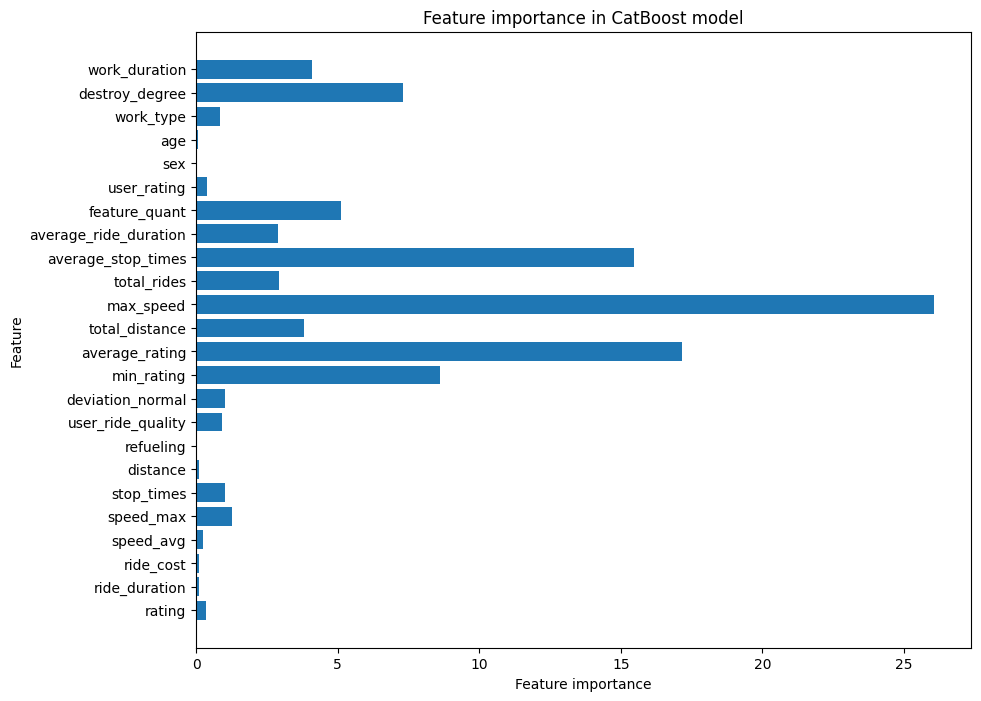

In [37]:
# Визуализация важности признаков в CatBoost

import matplotlib.pyplot as plt

feature_importances = clf.get_feature_importance()
features = X_train.columns

plt.figure(figsize=(10, 8))
plt.barh(features, feature_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Feature importance in CatBoost model")
plt.show()

Мы видим что максимальная скорость больше всего влияет на наш таргет. Так же некоторые из тех признаков которые мы создали сами оказывают большое влияние

In [38]:
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.8 MB/s eta 0:00:00


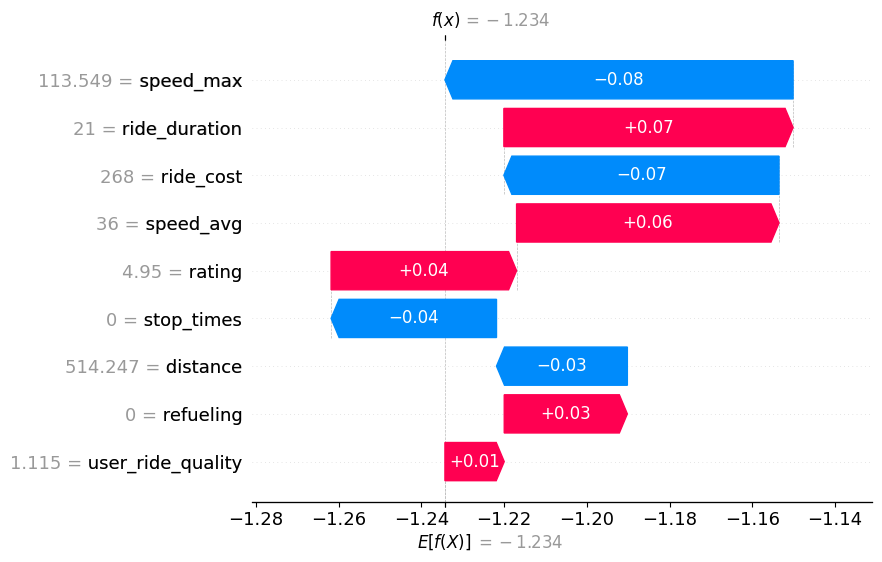

In [43]:
# Waterfall Plot из библиотеки SHAP

import shap

# Инициализация объяснителя SHAP и вычисление SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Expected_value для первого класса
expected_value = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value

# Создание объекта Explanation для первого наблюдения
expl = shap.Explanation(values=shap_values[0][0],
                        base_values=expected_value,
                        data=X_test.iloc[0,:],
                        feature_names=X_test.columns.tolist())

# Визуализация Waterfall Plot
shap.initjs()
shap.plots.waterfall(expl, max_display=10)

На диаграмме показано, как отдельные признаки повлияли на изменение предсказания от базового значения для конкретного прогноза. Синие столбцы указывают на то, что признак уменьшил значение предсказания модели для данного наблюдения, в то время как красные столбцы указывают на увеличение.

Влияние отдельных признаков:
* speed_max значительно уменьшила значение предсказания;
* ride_duration и speed_avg увеличили значение предсказания;
* ride_cost и rating также увеличили значение, но в меньшей степени;
* stop_times и distance уменьшили значение предсказания;
* refueling и user_ride_quality имели незначительное положительное влияние на значение предсказания.

In [45]:
# Classification Report из scikit-learn

from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    another_bug       1.00      1.00      1.00     15788
      break_bug       1.00      1.00      1.00     15446
    electro_bug       1.00      1.00      1.00     14356
   engine_check       1.00      1.00      1.00     15651
    engine_fuel       1.00      1.00      1.00     15186
engine_ignition       1.00      1.00      1.00     15730
engine_overheat       1.00      1.00      1.00     16864
     gear_stick       1.00      1.00      1.00     15899
    wheel_shake       1.00      1.00      1.00      9517

       accuracy                           1.00    134437
      macro avg       1.00      1.00      1.00    134437
   weighted avg       1.00      1.00      1.00    134437



Значение точности равно 1.00 для каждого класса. Это означает, что когда модель предсказывает определенный класс, она почти всегда правильна.

Значение полноты также равно 1.00 для каждого класса, указывая на то, что модель корректно идентифицирует все истинные случаи каждого класса.

F1-балл также равен 1.00 для каждого класса. Это показывает исключительное балансирование между точностью и полнотой модели.

Общая точность модели составляет 1.00, что означает, что почти каждое предсказание было верным.

Количество наблюдений для каждого класса достаточно сбалансировано, с небольшим варьированием в размерах классов. Наименьший класс wheel_shake имеет 9517 примеров, в то время как наибольший класс engine_overheat имеет 16864 примеров. Это указывает на то, что датасет хорошо сбалансирован, и модель была способна научиться распознавать все классы эффективно.

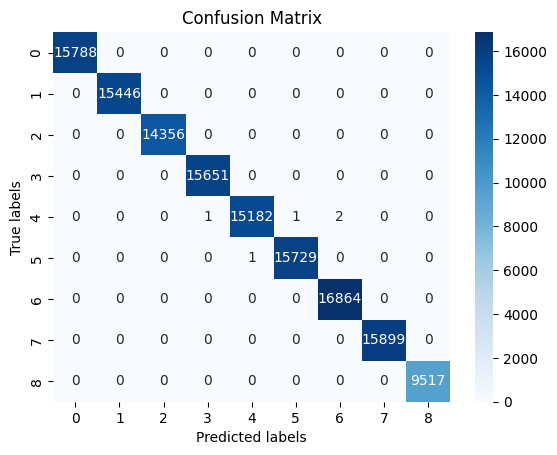

In [47]:
# Визуализация Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Из предоставленной confusion matrix видно, что почти все предсказания модели точны, так как основная диагональ, которая указывает на количество верных предсказаний для каждого класса, содержит значения, равные размеру support, и нет значений вне этой диагонали, за исключением небольшого количества случаев.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [23]:
# YOUR CODE HERE
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.6 MB/s eta 0:00:00


In [24]:
import optuna

from catboost import CatBoostClassifier
from sklearn.model_selection import KFold

In [36]:
features2drop = ['user_id', 'car_id', 'ride_id', 'ride_date'] # то, что надо выбросить
targets = ['target_class'] # таргеты
cat_features = ['work_type'] # категориальные признаки

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in df.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 1 ['work_type']
Числовые признаки: 23 ['rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating', 'average_rating', 'total_distance', 'max_speed', 'total_rides', 'average_stop_times', 'average_ride_duration', 'feature_quant', 'user_rating', 'sex', 'age', 'destroy_degree', 'work_duration']
Целевые переменные ['target_class']


In [37]:
X = df[filtered_features].drop(targets, axis=1, errors="ignore")
y = df["target_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [43]:
# объявим функцию objective

def objective(trial):
    # Гиперпараметры для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 1e1, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'loss_function': 'MultiClass',
        'eval_metric': 'Accuracy',
        'random_seed': 12345,
        'verbose': False
    }

    # Создание и обучение модели
    model = CatBoostClassifier(**params,
                               thread_count=-1,
                               cat_features=cat_features)

    model.fit(X_train,
              y_train,
              eval_set=(X_test, y_test),
              use_best_model=True,
              plot=False,
              early_stopping_rounds=50)

    # Предсказание и оценка модели
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)

    return accuracy

In [44]:
# Запустим
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2024-03-29 07:57:11,715] A new study created in memory with name: no-name-cc50e82c-f929-496f-a720-1c62cb72e248
[I 2024-03-29 08:08:47,241] Trial 0 finished with value: 0.9590518577290703 and parameters: {'iterations': 201, 'depth': 8, 'learning_rate': 0.0914721376208554, 'random_strength': 83, 'l2_leaf_reg': 7.253600739123751, 'border_count': 139}. Best is trial 0 with value: 0.9590518577290703.
[I 2024-03-29 08:16:33,274] Trial 1 finished with value: 0.98309014046093 and parameters: {'iterations': 254, 'depth': 4, 'learning_rate': 0.13135599960537145, 'random_strength': 5, 'l2_leaf_reg': 3.644668056298174, 'border_count': 150}. Best is trial 1 with value: 0.98309014046093.
[I 2024-03-29 08:18:31,051] Trial 2 finished with value: 0.8983920756728612 and parameters: {'iterations': 95, 'depth': 4, 'learning_rate': 0.18072826156652833, 'random_strength': 78, 'l2_leaf_reg': 1.1529393788621547, 'border_count': 102}. Best is trial 1 with value: 0.98309014046093.
[I 2024-03-29 08:37:25,789]

KeyboardInterrupt: 

In [45]:
# Вывод лучших гиперпараметров
print(study.best_params)

{'iterations': 263, 'depth': 8, 'learning_rate': 0.21920847713899486, 'random_strength': 71, 'l2_leaf_reg': 0.1807143025314617, 'border_count': 158}


In [48]:
# Обучение модели с оптимизированными гиперпараметрами
optimized_model = CatBoostClassifier(**study.best_params)
optimized_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, cat_features=cat_features)

0:	learn: 1.6112050	test: 1.6066345	best: 1.6066345 (0)	total: 8.77s	remaining: 38m 18s
1:	learn: 1.4271569	test: 1.4222974	best: 1.4222974 (1)	total: 16.4s	remaining: 35m 34s
2:	learn: 1.1738624	test: 1.1716711	best: 1.1716711 (2)	total: 21.7s	remaining: 31m 24s
3:	learn: 1.0536400	test: 1.0520006	best: 1.0520006 (3)	total: 29s	remaining: 31m 14s
4:	learn: 1.0127582	test: 1.0109159	best: 1.0109159 (4)	total: 33.6s	remaining: 28m 53s
5:	learn: 0.9892800	test: 0.9870803	best: 0.9870803 (5)	total: 34.7s	remaining: 24m 45s
6:	learn: 0.9454842	test: 0.9434495	best: 0.9434495 (6)	total: 39.8s	remaining: 24m 14s
7:	learn: 0.8969135	test: 0.8945069	best: 0.8945069 (7)	total: 43.6s	remaining: 23m 8s
8:	learn: 0.8342199	test: 0.8323977	best: 0.8323977 (8)	total: 46.8s	remaining: 22m
9:	learn: 0.8093636	test: 0.8075749	best: 0.8075749 (9)	total: 47.8s	remaining: 20m 10s
10:	learn: 0.8002269	test: 0.7985899	best: 0.7985899 (10)	total: 49s	remaining: 18m 43s
11:	learn: 0.7962335	test: 0.7945085	be

In [49]:
# Оценка модели с новыми гиперпараметрами
optimized_preds = optimized_model.predict(X_test)
optimized_accuracy = accuracy_score(y_test, optimized_preds)
print(f'Optimized Model Accuracy: {optimized_accuracy:.4f}')

Optimized Model Accuracy: 1.0000


Ввиду долго обучения, остановил его при достижении модели оптимального качества.

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.